In [5]:
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import gc

# Dataset directory
dataset_dir = 'dataset/'

# Define the target shape for images
TARGET_SHAPE = (64, 64, 3)

In [6]:
# Data sampling: Select 10-20% of the dataset
sampling_fraction = 0.15  # Adjust this between 0.1 and 0.2 for 10-20% sampling
file_list = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) if f.endswith('.npz')]
sampled_file_list = random.sample(file_list, int(len(file_list) * sampling_fraction))
print(f"Number of files sampled: {len(sampled_file_list)}")

Number of files sampled: 329


In [7]:
# Resize function
def resize_image(image):
    return resize(image, TARGET_SHAPE, preserve_range=True, anti_aliasing=True)

# Function to load .npz files using memory mapping
def load_npz_file(file_path):
    data = np.load(file_path, mmap_mode='r')  # Memory-mapped to avoid loading entirely into RAM
    color_images = data['colorImages'] / 255.0  # Normalize images
    color_images_resized = np.array([resize_image(img) for img in color_images.transpose(3, 0, 1, 2)])
    
    bounding_boxes = data['boundingBox']
    landmarks_2d = data['landmarks2D']
    landmarks_3d = data['landmarks3D']
    
    gc.collect()  # Free memory after loading
    return color_images_resized, bounding_boxes, landmarks_2d, landmarks_3d

In [8]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data generator with reduced batch size and single-threaded processing
def data_generator(file_list, batch_size=2):
    while True:
        for i in range(0, len(file_list), batch_size):
            batch_files = file_list[i:i + batch_size]
            images = []
            
            with ThreadPoolExecutor(max_workers=1) as executor:  # Reduced to single thread for stability
                results = list(tqdm(executor.map(load_npz_file, batch_files), total=len(batch_files), desc="Loading batch"))
            
            for result in results:
                color_images, _, _, _ = result
                images.append(color_images)
            
            images = np.concatenate(images, axis=0)
            augmented_images = np.array([datagen.random_transform(img) for img in images])
            
            gc.collect()  # Manually trigger garbage collection to free memory
            
            yield augmented_images, augmented_images


In [9]:
# Split the sampled file list into training and validation sets
train_files, val_files = train_test_split(sampled_file_list, test_size=0.2, random_state=42)
gc.collect()  # Free memory after splitting data

475

In [10]:

# Example usage of data_generator
train_gen = data_generator(train_files, batch_size=2)
val_gen = data_generator(val_files, batch_size=2)

# Example on how to fetch a batch
train_batch = next(train_gen)
print(f"Sample batch shape: {train_batch[0].shape}")

Loading batch: 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]


Sample batch shape: (232, 64, 64, 3)


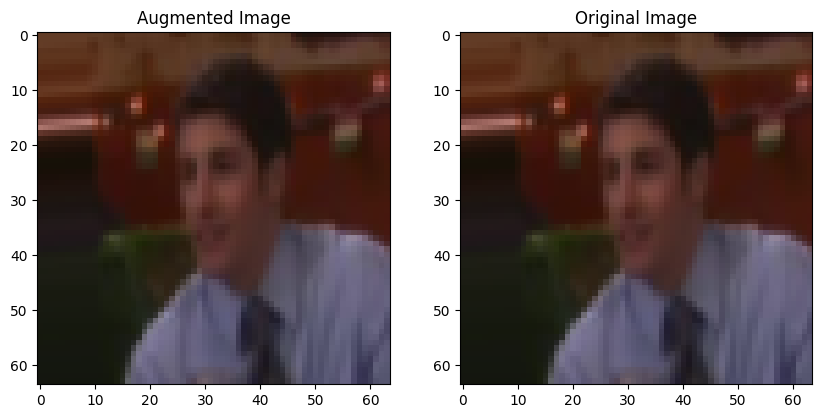

In [11]:
# Example of plotting the first image from the batch (original vs augmented)
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(train_batch[0][0])  # Augmented image
plt.title("Augmented Image")

plt.subplot(1, 2, 2)
plt.imshow(train_batch[1][0])  # Original image (since this is autoencoder-style training, original and augmented are same)
plt.title("Original Image")
plt.show()